In [1]:
from transformers import ViTImageProcessor, ViTForImageClassification, ViTModel, ViTConfig
from maskgen.vision_models.vision_maskgen import MaskGeneratingModel, convert_to_peft
from maskgen.utils import get_preprocess, collate_fn, load_imagenet
# from maskgen.utils.img_utils import plot_overlap_np
from torch.utils.data import DataLoader
import torch
import json
import os
from tqdm import tqdm
import numpy as np
from typing import Dict, Any

def load_config(config_path: str) -> Dict[str, Any]:
    """Load configuration from JSON file."""
    with open(config_path, 'r') as f:
        config = json.load(f)
    
    # Flatten config for easier access
    flat_config = {}
    flat_config.update(config['evaluation'])
    flat_config.update(config['model'])
    flat_config.update(config['dataset'])
    
    return flat_config


In [121]:
# Load configuration
config = load_config('eval_config.json')

# Create results directory if it doesn't exist
if not os.path.exists(config['results_path']):
    os.makedirs(config['results_path'])

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load models and processor
pretrained_name = config['pretrained_name']
vit_config = ViTConfig.from_pretrained(pretrained_name)
processor = ViTImageProcessor.from_pretrained(pretrained_name)

# Get image normalization parameters
img_mean = processor.image_mean
img_std = processor.image_std

# Target model for explanation
target_model = ViTForImageClassification.from_pretrained(pretrained_name)
target_model.eval()
target_model.to(device)

# Load trained weights
maskgen_model = MaskGeneratingModel.load_model(base_model_name=pretrained_name, 
                                save_path=config['model_path'], 
                                hidden_size=vit_config.hidden_size, 
                                num_classes=vit_config.num_labels)
maskgen_model.eval()
maskgen_model.to(device)

print() 

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Converted base model layers to PEFT: ['encoder.layer.0.attention.attention.query', 'encoder.layer.0.attention.attention.key', 'encoder.layer.0.attention.attention.value', 'encoder.layer.0.attention.output.dense', 'encoder.layer.0.intermediate.dense', 'encoder.layer.0.output.dense', 'encoder.layer.1.attention.attention.query', 'encoder.layer.1.attention.attention.key', 'encoder.layer.1.attention.attention.value', 'encoder.layer.1.attention.output.dense', 'encoder.layer.1.intermediate.dense', 'encoder.layer.1.output.dense', 'encoder.layer.2.attention.attention.query', 'encoder.layer.2.attention.attention.key', 'encoder.layer.2.attention.attention.value', 'encoder.layer.2.attention.output.dense', 'encoder.layer.2.intermediate.dense', 'encoder.layer.2.output.dense', 'encoder.layer.3.attention.attention.query', 'encoder.layer.3.attention.attention.key', 'encoder.layer.3.attention.attention.value', 'encoder.layer.3.attention.output.dense', 'encoder.layer.3.intermediate.dense', 'encoder.layer

Predicted class: projector


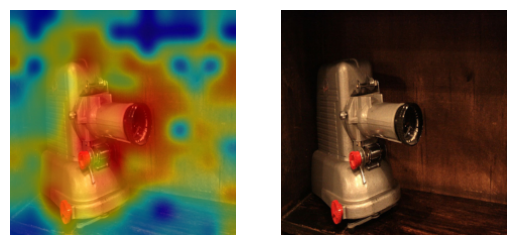

In [124]:
import requests
from PIL import Image
from maskgen.utils.img_utils import plot_overlap_np

# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
# url = "http://farm3.staticflickr.com/2066/1798910782_5536af8767_z.jpg"
# url = "http://farm1.staticflickr.com/184/399924547_98e6cef97a_z.jpg"
# url = "http://farm1.staticflickr.com/128/318959350_1a39aae18c_z.jpg"
# url = "http://farm9.staticflickr.com/8490/8179481059_41be7bf062_z.jpg"
# url = "http://farm1.staticflickr.com/76/197438957_b20800e7cf_z.jpg"
# url = "http://farm3.staticflickr.com/2284/5730266001_7d051b01b7_z.jpg"
# url = "https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n01491361_tiger_shark.JPEG?raw=true"
# url = "https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n03000684_chain_saw.JPEG?raw=true"
url = "https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n04009552_projector.JPEG?raw=true"
image = Image.open(requests.get(url, stream=True).raw)

with torch.no_grad():
    inputs = processor(images=image, return_tensors="pt")
    inputs.to(device)
    img = inputs['pixel_values']
    img = img.to(device)
    predicted_class_idx = target_model(img).logits.argmax(-1).item()
    secondary_class_idx = target_model(img).logits.argsort(descending=True)[0][1].item()

label = predicted_class_idx
# label = secondary_class_idx
label = torch.tensor([label]).to(device)

print("Predicted class:", target_model.config.id2label[label.item()])

# heatmap = torch.sigmoid(sim_logits).reshape(N, size, size)
heatmap = maskgen_model.attribute_img(img, label.unsqueeze(1), image_size=224, patch_size=16)
# heatmap = sim_logits.reshape(N, size, size)

heatmap = heatmap.squeeze(0).detach().cpu().numpy()
img = img.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)
img_int, heatmap_img = plot_overlap_np(img, heatmap, img_mean, img_std)

In [116]:
heatmap

array([[0.62249756, 0.6986898 , 0.6931393 , 0.6024244 , 0.6165316 ,
        0.60822266, 0.5923867 , 0.5912282 , 0.6901801 , 0.61451197,
        0.65844035, 0.6361158 , 0.6168892 , 0.59941983],
       [0.5825361 , 0.6927893 , 0.58878547, 0.6265101 , 0.602416  ,
        0.6005028 , 0.69302726, 0.686738  , 0.68747336, 0.6917518 ,
        0.68765736, 0.6905245 , 0.60993737, 0.699155  ],
       [0.5812922 , 0.61433876, 0.6190994 , 0.5949633 , 0.5700423 ,
        0.5840881 , 0.5956008 , 0.597801  , 0.6987646 , 0.587229  ,
        0.5834005 , 0.606822  , 0.59824884, 0.5780662 ],
       [0.57834274, 0.72767437, 0.584188  , 0.5841291 , 0.5769954 ,
        0.5851305 , 0.61098236, 0.5868075 , 0.5838396 , 0.58251834,
        0.6934688 , 0.6282908 , 0.6908999 , 0.58347714],
       [0.6906291 , 0.63294244, 0.5854906 , 0.6037481 , 0.5739534 ,
        0.5761585 , 0.59040916, 0.6099693 , 0.60456103, 0.5873514 ,
        0.61901546, 0.64895153, 0.578933  , 0.57250965],
       [0.67209214, 0.61700433, 0.5